# TorchDyn Quickstart

**TorchDyn is the toolkit for continuous models in PyTorch. Play with state-of-the-art architectures or use its powerful libraries to create your own.**


Central to the `torchdyn` approach are continuous neural networks, where *width*, *depth* (or both) are taken to their infinite limit. On the optimization front, we consider continuous "data-stream" regimes and gradient flow methods, where the dataset represents a time-evolving signal processed by the neural network to adapt its parameters. 

By providing a centralized, easy-to-access collection of model templates, tutorial and application notebooks, we hope to speed-up research in this area and ultimately contribute to turning neural differential equations into an effective tool for control, system identification and common machine learning tasks.


In [1]:
from torchdyn.models import *
from torchdyn.data_utils import *
from torchdyn import *

## Generate data from a static toy dataset 

We’ll be generating data from toy datasets. We provide a wide range of datasets often use to benchmark and understand neural ODEs. Here we will use the classic moons dataset and train a neural ODE for binary classification

In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=520, dataset_type='moons')        

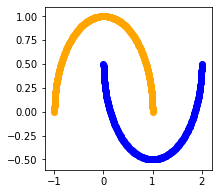

In [3]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

Generated data can be easily loaded in the dataloader with standard `PyTorch` calls

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

The learner is defined as.... 

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Define a  Neural ODE

Analogously to most forward neural models we want to realize a map 

$$
        x \mapsto \hat y
$$

where  $\hat y$ becomes the best approximation of a true output $y$ given an input $x$.\
In torchdyn you can define very simple neural ODE models of the form 

$$ \left\{
    \begin{aligned}
        \dot{h}(s) &= f(h(s), \theta)\\
        h(0) &= x\\
        \hat y & = h(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

by just specifying a neural network $f$ and giving some simple settings.

**Note:** This neural ODE model is of *depth-invariant* type as neither $f$ explicitly depend on $s$ nor the parameters $\theta$ are depth-varying. Together with their *depth-variant* counterpart with $s$ concatenated in the vector field was first proposed and implemeted by [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366)

### Define the vector field (DEFunc) 

The first step is to define a `torch.nn.Sequential` object and wrap it with the `DEFunc` class from torchdyn. This automatically defines the vector field $f(h,\theta)$ of the neural ODE

In [6]:
f = DEFunc(nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(),
        nn.Linear(64, 2)                       
    )
)

In this case we chose $f$ to be a simple MLP with one hidden layer and $\tanh$ activation

### Define the NeuralDE

The final step to define a neural ODE object is to instantiate an object of the torchdyn's class `NeuralDE` passing some preferences and `f`.

In this case with `settings` we just specify that:

* we want a `'classic'` neural ODE;
* we will use the `'dopri5'` (Dormand-Prince) ODE solver from `torchdiffeq`;
* we compute backward gradients with the `'adjoint'` method.

In [7]:
settings = {'type':'classic', 'solver':'dopri5', 'backprop_style':'adjoint'}
model = NeuralDE(f, settings).to(device)

## Train the Model

In [8]:
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=200, max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 322   
1 | model.defunc     | DEFunc     | 322   
2 | model.defunc.m   | Sequential | 322   
3 | model.defunc.m.0 | Linear     | 192   
4 | model.defunc.m.1 | Tanh       | 0     
5 | model.defunc.m.2 | Linear     | 130   
6 | model.adjoint    | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

With the method `trajectory` of `NeuralDE` objects you can quickly evaluate the entire trajectory of each data point in `X_train` on an interval `s_span`

In [9]:
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

### Plot the Training Results

We can first plot the trajectories of the data points in the depth domain $s$

Text(0.5, 1.0, 'Dimension 1')

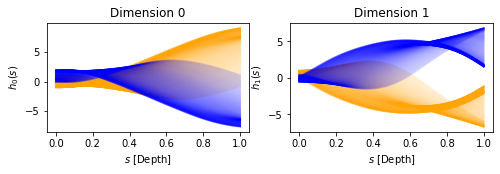

In [10]:
color=['orange', 'blue']

fig = plt.figure(figsize=(8,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(s_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(s_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
    
ax0.set_xlabel(r"$s$ [Depth]")
ax0.set_ylabel(r"$h_0(s)$")
ax0.set_title("Dimension 0")
ax1.set_xlabel(r"$s$ [Depth]")
ax1.set_ylabel(r"$h_1(s)$")
ax1.set_title("Dimension 1")

Then the trajectory in the *state-space*

Text(0.5, 1.0, 'Flows in the state-space')

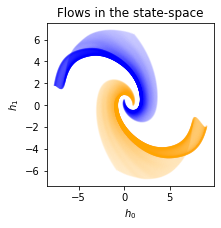

In [11]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(500):
    ax.plot(trajectory[:,i,0], trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
    
ax.set_xlabel(r"$h_0$")
ax.set_ylabel(r"$h_1$")
ax.set_title("Flows in the state-space")

As you can see, the neural ODE steers the data-points into regions of null loss with a continuous flow in the depth domain.\ Finally, we can also plot the learned vector field $f$

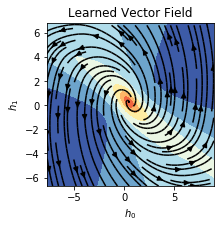

In [12]:
plot_static_vector_field(model, trajectory)

**Sweet! You trained your first neural ODE! Now go on and learn more advanced models with the next tutorials**